In [1]:
from IPython.core.display import display, HTML, Javascript

# ----- Notebook Theme -----
color_map = ['#16a085', '#e8f6f3', '#d0ece7', '#a2d9ce', '#73c6b6', '#45b39d', 
                        '#16a085', '#138d75', '#117a65', '#0e6655', '#0b5345']

prompt = color_map[-1]
main_color = color_map[0]
strong_main_color = color_map[1]
custom_colors = [strong_main_color, main_color]

css_file = ''' 

div #notebook {
background-color: white;
line-height: 20px;
}

#notebook-container {
%s
margin-top: 2em;
padding-top: 2em;
border-top: 4px solid %s; /* light orange */
-webkit-box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
    box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
}

div .input {
margin-bottom: 1em;
}

.rendered_html h1, .rendered_html h2, .rendered_html h3, .rendered_html h4, .rendered_html h5, .rendered_html h6 {
color: %s; /* light orange */
font-weight: 600;
}

div.input_area {
border: none;
    background-color: %s; /* rgba(229, 143, 101, 0.1); light orange [exactly #E58F65] */
    border-top: 2px solid %s; /* light orange */
}

div.input_prompt {
color: %s; /* light blue */
}

div.output_prompt {
color: %s; /* strong orange */
}

div.cell.selected:before, div.cell.selected.jupyter-soft-selected:before {
background: %s; /* light orange */
}

div.cell.selected, div.cell.selected.jupyter-soft-selected {
    border-color: %s; /* light orange */
}

.edit_mode div.cell.selected:before {
background: %s; /* light orange */
}

.edit_mode div.cell.selected {
border-color: %s; /* light orange */

}
'''
def to_rgb(h): 
    return tuple(int(h[i:i+2], 16) for i in [0, 2, 4])

main_color_rgba = 'rgba(%s, %s, %s, 0.1)' % (to_rgb(main_color[1:]))
open('notebook.css', 'w').write(css_file % ('width: 95%;', main_color, main_color, main_color_rgba, main_color,  main_color, prompt, main_color, main_color, main_color, main_color))

def nb(): 
    return HTML("<style>" + open("notebook.css", "r").read() + "</style>")
nb()

<img src="https://github.com/sberbank-ai-lab/LightAutoML/raw/master/imgs/LightAutoML_logo_big.png" alt="LightAutoML logo" style="width:70%;"/>

# LightAutoML baseline

Official LightAutoML github repository is [here](https://github.com/sberbank-ai-lab/LightAutoML). 

### Do not forget to put upvote for the notebook and the ⭐️ for github repo if you like it using the button below - one click for you, great pleasure for us ☺️ 

In [2]:
s = '<iframe src="https://ghbtns.com/github-btn.html?user=sberbank-ai-lab&repo=LightAutoML&type=star&count=true&size=large" frameborder="0" scrolling="0" width="170" height="30" title="LightAutoML GitHub"></iframe>'
HTML(s)

/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## 0. Prerequisites

### 0.0. install LightAutoML

In [3]:
%%capture
!pip install -U lightautoml

### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: presets for AutoML, task and report generation module

In [4]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

### 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [5]:
N_THREADS = 4 
RANDOM_STATE = 21
TIMEOUT = 8 * 3600
TARGET_NAME = 'congestion'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [6]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [7]:
INPUT_DIR = '../input/tabular-playground-series-mar-2022/'

In [8]:
train_data = pd.read_csv(INPUT_DIR + 'train.csv', dtype={'time': str})
print(train_data.shape)
train_data.head()

(848835, 6)


,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848835 entries, 0 to 848834
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   row_id      848835 non-null  int64 
 1   time        848835 non-null  object
 2   x           848835 non-null  int64 
 3   y           848835 non-null  int64 
 4   direction   848835 non-null  object
 5   congestion  848835 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 38.9+ MB


In [10]:
test_data = pd.read_csv(INPUT_DIR + 'test.csv', dtype={'time': str})
print(test_data.shape)
test_data.head()

(2340, 5)


,row_id,time,x,y,direction
0,848835,1991-09-30 12:00:00,0,0,EB
1,848836,1991-09-30 12:00:00,0,0,NB
2,848837,1991-09-30 12:00:00,0,0,SB
3,848838,1991-09-30 12:00:00,0,1,EB
4,848839,1991-09-30 12:00:00,0,1,NB


In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   row_id     2340 non-null   int64 
 1   time       2340 non-null   object
 2   x          2340 non-null   int64 
 3   y          2340 non-null   int64 
 4   direction  2340 non-null   object
dtypes: int64(3), object(2)
memory usage: 91.5+ KB


In [12]:
submission = pd.read_csv(INPUT_DIR + 'sample_submission.csv')
print(submission.shape)
submission.head()

(2340, 2)


,row_id,congestion
0,848835,0.0
1,848836,0.0
2,848837,0.0
3,848838,0.0
4,848839,0.0


### 0.5. Feature engineering
Let's make some new features:

In [13]:
def feature_engineering(data):
    data['time'] = pd.to_datetime(data['time'])
    data['month'] = data['time'].dt.month
    data['weekday'] = data['time'].dt.weekday
    data['hour'] = data['time'].dt.hour
    data['minute'] = data['time'].dt.minute
    data['is_month_start'] = data['time'].dt.is_month_start.astype('int')
    data['is_month_end'] = data['time'].dt.is_month_end.astype('int')
    data['hour+minute'] = data['time'].dt.hour * 60 + data['time'].dt.minute
    data['is_weekend'] = (data['time'].dt.dayofweek > 4).astype('int')
    data['is_afternoon'] = (data['time'].dt.hour > 12).astype('int')
    data['x+y'] = data['x'].astype('str') + data['y'].astype('str')
    data['x+y+direction'] = data['x'].astype('str') + data['y'].astype('str') + data['direction'].astype('str')
    data['hour+direction'] = data['hour'].astype('str') + data['direction'].astype('str')
    data['hour+x+y'] = data['hour'].astype('str') + data['x'].astype('str') + data['y'].astype('str')
    data['hour+direction+x'] = data['hour'].astype('str') + data['direction'].astype('str') + data['x'].astype('str')
    data['hour+direction+y'] = data['hour'].astype('str') + data['direction'].astype('str') + data['y'].astype('str')
    data['hour+direction+x+y'] = data['hour'].astype('str') + data['direction'].astype('str') + data['x'].astype('str') + data['y'].astype('str')
    data['hour+x'] = data['hour'].astype('str') + data['x'].astype('str')
    data['hour+y'] = data['hour'].astype('str') + data['y'].astype('str')
    data = data.drop(['time'], axis=1)
    return data

In [14]:
for data in [train_data, test_data]:
    data = feature_engineering(data)

# 1. Task definition

### 1.1. Task type

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [15]:
task = Task('reg', metric='mae', loss='mae')

### 1.2. Feature roles setup
To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [16]:
roles = {'target': TARGET_NAME,
         'drop': ['row_id']
         }

### 1.3. LightAutoML model creation - TabularAutoML preset

In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

<img src="https://github.com/sberbank-ai-lab/LightAutoML/raw/master/imgs/tutorial_blackbox_pipeline.png" alt="TabularAutoML preset pipeline" style="width:85%;"/>

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/sberbank-ai-lab/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we will use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one. 

In [17]:
%%time 

automl = TabularAutoML(task = task,
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'random_state': RANDOM_STATE},
                       general_params = {'use_algos': [['lgb']]}
                      )

CPU times: user 19.6 ms, sys: 0 ns, total: 19.6 ms
Wall time: 19.6 ms


# 2. AutoML training

To run autoML training use fit_predict method:
- `train_data` - Dataset to train.
- `roles` - Roles dict.
- `verbose` - Controls the verbosity: the higher, the more messages.
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [18]:
oof_pred = automl.fit_predict(train_data, roles = roles, verbose=3)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

[18:07:33] Stdout logging level is INFO3.
[18:07:33] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[18:07:33] Task: reg

[18:07:33] Start automl preset with listed constraints:
[18:07:33] - time: 28800.00 seconds
[18:07:33] - CPU: 4 cores
[18:07:33] - memory: 16 GB

[18:07:33] Train data shape: (848835, 24)

[18:07:45] Feats was rejected during automatic roles guess: []
[18:07:46] Layer 1 train process start. Time left 28786.74 secs
[18:07:50] [1]	valid's l1: 13.3978
[18:07:50] Training until validation scores don't improve for 100 rounds
[18:08:04] [100]	valid's l1: 6.41383
[18:08:15] [200]	valid's l1: 6.24256
[18:08:25] [300]	valid's l1: 6.16735
[18:08:32] [400]	valid's l1: 6.1167
[18:08:40] [500]	valid's l1: 6.07768
[18:08:47] [600]	valid's l1: 6.04725
[18:08:54] [700]	valid's l1: 6.02376
[18:09:01] [800]	valid's l1: 6.00317
[18:09:07] [900]	valid's l1: 5.98455
[18:09:14] [1000]	valid's l1: 5.96802
[18:09:20] [1100]	valid's l1: 5.

/opt/conda/lib/python3.7/site-packages/lightautoml/transformers/categorical.py:460: RuntimeWarning: invalid value encountered in true_divide
  folds_prior = (f_sum.sum() - f_sum) / (f_count.sum() - f_count)
/opt/conda/lib/python3.7/site-packages/lightautoml/transformers/categorical.py:460: RuntimeWarning: invalid value encountered in true_divide
  folds_prior = (f_sum.sum() - f_sum) / (f_count.sum() - f_count)
/opt/conda/lib/python3.7/site-packages/lightautoml/transformers/categorical.py:460: RuntimeWarning: invalid value encountered in true_divide
  folds_prior = (f_sum.sum() - f_sum) / (f_count.sum() - f_count)
/opt/conda/lib/python3.7/site-packages/lightautoml/transformers/categorical.py:460: RuntimeWarning: invalid value encountered in true_divide
  folds_prior = (f_sum.sum() - f_sum) / (f_count.sum() - f_count)


[18:12:46] [700]	valid's l1: 6.23072
[18:12:56] [800]	valid's l1: 6.20783
[18:13:05] [900]	valid's l1: 6.19177
[18:13:14] [1000]	valid's l1: 6.17991
[18:13:24] [1100]	valid's l1: 6.16263
[18:13:33] [1200]	valid's l1: 6.15307
[18:13:42] [1300]	valid's l1: 6.14369
[18:13:51] [1400]	valid's l1: 6.13449
[18:14:00] [1500]	valid's l1: 6.12654
[18:14:09] [1600]	valid's l1: 6.12001
[18:14:18] [1700]	valid's l1: 6.11191
[18:14:27] [1800]	valid's l1: 6.10551
[18:14:36] [1900]	valid's l1: 6.10015
[18:14:45] [2000]	valid's l1: 6.09509
[18:15:01] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[18:15:03] [1]	valid's l1: 13.3904
[18:15:03] Training until validation scores don't improve for 100 rounds
[18:15:18] [100]	valid's l1: 6.35661
[18:15:31] [200]	valid's l1: 6.32111
[18:15:41] [300]	valid's l1: 6.31458
[18:15:51] [400]	valid's l1: 6.29932
[18:16:01] [500]	valid's l1: 6.28593
[18:16:15] [600]	valid's l1: 6.2718
[18:16:25] [700]	valid's l1: 6.25659
[18:16:35] [800]	valid's

CPU times: user 147 ms, sys: 85.9 ms, total: 233 ms
Wall time: 123 ms


<AxesSubplot:xlabel='Feature'>

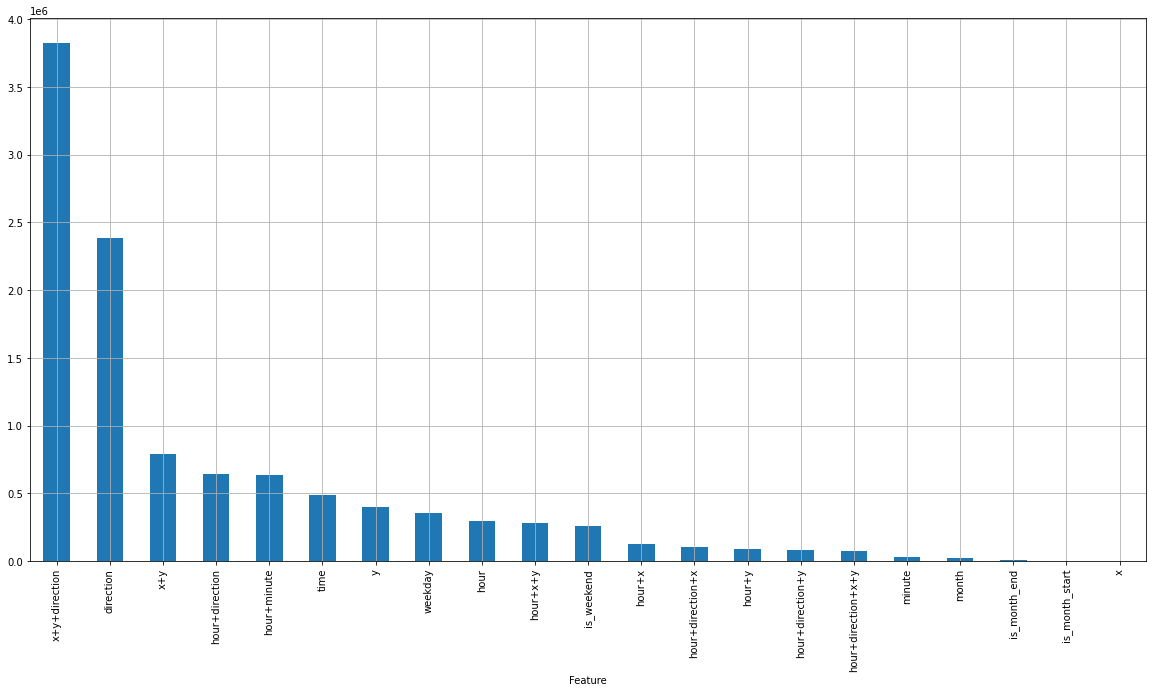

In [19]:
%%time

fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize=(20, 10), grid=True)

# 4. Predict for test dataset

In [20]:
%%time

test_pred = automl.predict(test_data)
print('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

Prediction for test data:
array([[46.027767],
       [34.16307 ],
       [48.574802],
       ...,
       [69.04426 ],
       [11.849389],
       [39.732124]], dtype=float32)
Shape = (2340, 1)
CPU times: user 4.51 s, sys: 2.03 ms, total: 4.51 s
Wall time: 1.24 s


In [21]:
submission[TARGET_NAME] = test_pred.data[:, 0]
submission.to_csv('lightautoml_tabularautoml.csv', index=False)
submission

,row_id,congestion
0,848835,46.027767
1,848836,34.163071
2,848837,48.574802
3,848838,25.823097
4,848839,68.745132
...,...,...
2335,851170,66.414696
2336,851171,26.906914
2337,851172,69.044258
2338,851173,11.849389


In [22]:
submission.describe()

,row_id,congestion
count,2340.000000,2340.000000
mean,850004.500000,49.813446
std,675.644137,14.336147
min,848835.000000,11.849389
25%,849419.750000,38.895379
50%,850004.500000,49.298330
75%,850589.250000,61.782782
max,851174.000000,80.931892


# Additional materials

- [Official LightAutoML github repo](https://github.com/sberbank-ai-lab/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)
- [LightAutoML tutorials](https://github.com/sberbank-ai-lab/LightAutoML/tree/master/examples/tutorials)
- LightAutoML course:
    - [Part 1 - general overview](https://ods.ai/tracks/automl-course-part1) 
    - [Part 2 - LightAutoML specific applications](https://ods.ai/tracks/automl-course-part2)
    - [Part 3 - LightAutoML customization](https://ods.ai/tracks/automl-course-part3)
- [OpenDataScience AutoML benchmark leaderboard](https://ods.ai/competitions/automl-benchmark/leaderboard)

### If you still like the notebook, do not forget to put upvote for the notebook and the ⭐️ for github repo if you like it using the button below - one click for you, great pleasure for us ☺️

In [23]:
s = '<iframe src="https://ghbtns.com/github-btn.html?user=sberbank-ai-lab&repo=LightAutoML&type=star&count=true&size=large" frameborder="0" scrolling="0" width="170" height="30" title="LightAutoML GitHub"></iframe>'
HTML(s)

/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
